# Numerical Experiments for PCA NML

In [56]:
import pandas as pd
import numpy as np
from sklearn import decomposition, model_selection, linear_model
import seaborn as sns
import itertools
from brokenaxes import brokenaxes
from scipy import interpolate
import kneed

%pylab inline

Populating the interactive namespace from numpy and matplotlib


/opt/homebrew/Cellar/python36/3.6.2+_254.20170915/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['test']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Loading the Data

We use data from the <a href="https://www.kaggle.com/szrlee/stock-time-series-20050101-to-20171231
">Kaggle DJIA Dataset</a>.

In [57]:
djia = pd.read_csv('../datasets/all_stocks_2006-01-01_to_2018-01-01.csv')
djia.head()

,Date,Open,High,Low,Close,Volume,Name
0,2006-01-03,77.76,79.35,77.24,79.11,3117200,MMM
1,2006-01-04,79.49,79.49,78.25,78.71,2558000,MMM
2,2006-01-05,78.41,78.65,77.56,77.99,2529500,MMM
3,2006-01-06,78.64,78.90,77.64,78.63,2479500,MMM
4,2006-01-09,78.50,79.83,78.46,79.02,1845600,MMM


In [58]:
djia = djia[['Date', 'Close', 'Name']].rename(columns=dict(Date='date', Close='close', Name='name')).set_index(['date', 'name']).unstack()
dija = djia - djia.mean()
djia.head()

close                                                          \
name         AABA   AAPL   AMZN    AXP     BA    CAT   CSCO    CVX    DIS   
date                                                                        
2006-01-03  40.91  10.68  47.58  52.58  70.44  57.80  17.45  59.08  24.40   
2006-01-04  40.97  10.71  47.25  51.95  71.17  59.27  17.85  58.91  23.99   
2006-01-05  41.53  10.63  47.65  52.50  70.33  59.27  18.35  58.19  24.41   
2006-01-06  43.21  10.90  47.87  52.68  69.35  60.45  18.77  59.25  24.74   
2006-01-09  43.42  10.86  47.08  53.99  68.77  61.55  19.06  58.95  25.00   

                   ...                                                   \
name           GE  ...   MSFT    NKE    PFE     PG    TRV    UNH    UTX   
date               ...                                                    
2006-01-03  35.37  ...  26.84  10.74  23.78  58.78  45.99  61.73  56.53   
2006-01-04  35.32  ...  26.97  10.69  24.55  58.89  46.50  61.88  56.19   
2006-01-05  35.23  ...  26.99  10.76  24.58  58.70  46.95  61.69  55.98   
2006-01-06  35.47  ...  26.91  10.72  24.85  58.64  47.21  62.90  56.16   
2006-01-09  35.38  ...  26.86  10.88  24.85  59.08  47.23  61.40  56.80   

                                 
name           VZ    WMT    XOM  
date                             
2006-01-03  30.38  46.23  58.47  
2006-01-04  31.27  46.32  58.57  
2006-01-05  31.63  45.69  58.28  
2006-01-06  31.35  45.88  59.43  
2006-01-09  31.48  45.71  59.40  

[5 rows x 31 columns]

In [59]:
len(djia)

3020

## Creating Return-Percentages

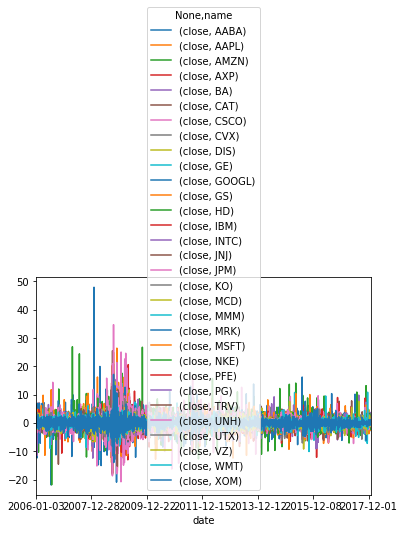

In [60]:
djia = 100 * (djia - djia.shift(1)) / djia.shift(1)
djia.plot();

In [61]:
def make_partial(k, tau):
    lhs = djia[dija.columns[: k]].fillna(0)
    m = len(djia.columns)
    rhs = pd.DataFrame(
        np.dot(np.random.randn(k, m - k).T, lhs.T).T + tau * np.random.randn(len(djia), m - k), 
        index=djia.index)
    return pd.concat([lhs, rhs], axis=1)
   
make_partial(20, 0.01)

,"(close, AABA)","(close, AAPL)","(close, AMZN)","(close, AXP)","(close, BA)","(close, CAT)","(close, CSCO)","(close, CVX)","(close, DIS)","(close, GE)",...,1,2,3,4,5,6,7,8,9,10
date,,,,,,,,,,,,,,,,,,,,,
2006-01-03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.008918,0.008269,-0.010025,0.009437,-0.010857,0.003886,-0.008041,-0.006428,0.001140,-0.013251
2006-01-04,0.146663,0.280899,-0.693569,-1.198174,1.036343,2.543253,2.292264,-0.287745,-1.680328,-0.141363,...,7.529078,6.553439,-2.039500,-3.169932,2.503849,-2.914372,-5.669672,-1.770270,0.026958,2.673159
2006-01-05,1.366854,-0.746965,0.846561,1.058710,-1.180273,0.000000,2.801120,-1.222203,1.750729,-0.254813,...,5.670134,-0.563903,-8.636228,-1.506667,-1.883988,-10.365836,-6.764902,-0.492797,-3.814742,5.561750
2006-01-06,4.045268,2.539981,0.461700,0.342857,-1.393431,1.990889,2.288828,1.821619,1.351905,0.681238,...,5.047346,9.478050,-13.356015,-0.950318,17.161941,8.552535,-4.940667,5.271063,7.587226,-5.158867
2006-01-09,0.485999,-0.366972,-1.650303,2.486712,-0.836337,1.819686,1.545019,-0.506329,1.050930,-0.253736,...,-1.657164,6.674224,-5.568445,-8.606739,-8.188954,4.438109,-2.262514,5.339525,2.762357,2.513797
2006-01-10,-1.013358,6.353591,-3.037383,-0.296351,0.479860,-0.406174,-0.472193,0.491942,1.280000,-0.537027,...,1.022641,2.729551,12.342742,5.664140,7.019166,19.489990,-3.555126,3.384960,-1.161886,-1.705106
2006-01-11,-2.582597,3.809524,-1.577218,-0.538733,1.447178,0.048940,2.266737,1.012829,0.947867,0.682012,...,3.877984,-5.862246,6.460378,5.687642,4.257299,9.245573,-10.436347,3.113925,-3.174129,8.426791
2006-01-12,-2.340578,0.417014,-1.268640,0.018678,-0.584879,1.434861,-1.030928,0.083556,0.312989,-1.213661,...,-3.085733,-2.116941,5.762951,-1.758385,-10.180758,-6.861391,1.697875,-3.751504,-9.025152,1.638415
2006-01-13,-2.421130,1.578073,0.090171,-0.205415,-0.301334,0.192895,-1.458333,0.784772,0.234009,0.285714,...,-0.412077,-0.092815,3.053389,-1.805953,0.087364,4.470971,-1.650734,-1.173434,-0.123643,0.586431


In [62]:
lin5 = make_partial(5, 0.001)
lin10 = make_partial(10, 0.001)

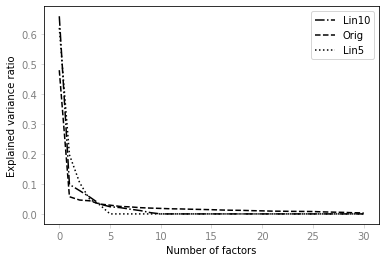

In [63]:
djia_pca = decomposition.PCA().fit(X=djia.dropna())
lin10_pca = decomposition.PCA().fit(X=lin10.dropna())
lin5_pca = decomposition.PCA().fit(X=lin5.dropna())

plot(lin10_pca.explained_variance_ratio_, '-.', label='Lin10', color='black');
plot(djia_pca.explained_variance_ratio_, '--', label='Orig', color='black');
plot(lin5_pca.explained_variance_ratio_, ':', label='Lin5', color='black');
legend();
xlabel('Number of factors').set_color('black');
ylabel('Explained variance ratio').set_color('black');
tick_params(color='lightgrey', labelcolor='grey');

savefig('../scree.png')

## Using the Kaiser Rule 

In [64]:
lin5_kaiser, lin10_kaiser, djia_kaiser = [], [], []
for i in range(20, len(djia)):
    lin5_kaiser.append((decomposition.PCA().fit(X=lin5.head(i).dropna()).explained_variance_ > 1).sum())
    lin10_kaiser.append((decomposition.PCA().fit(X=lin10.head(i).dropna()).explained_variance_ > 1).sum())
    djia_kaiser.append((decomposition.PCA().fit(X=djia.head(i).dropna()).explained_variance_ > 1).sum())

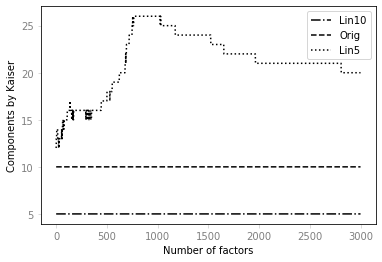

In [65]:
plot(lin5_kaiser, '-.', label='Lin10', color='black');
plot(lin10_kaiser, '--', label='Orig', color='black');
plot(djia_kaiser, ':', label='Lin5', color='black');
legend();
xlabel('Number of factors').set_color('black');
ylabel('Components by Kaiser').set_color('black');
tick_params(color='lightgrey', labelcolor='grey');

savefig('../kaiser.png')

## Finding the Knee in the Scree Plots

In [66]:
def find_knee(pca):
    y = pca.explained_variance_ratio_
    x = np.linspace(1, len(y), len(y))
    return kneed.KneeLocator(x, y, S=1.0, curve='convex', direction='decreasing').knee

lin5_knee, lin10_knee, djia_knee = [], [], []
for i in range(20, len(djia)):
    lin5_knee.append(find_knee(decomposition.PCA().fit(X=lin5.head(i).dropna())))
    lin10_knee.append(find_knee(decomposition.PCA().fit(X=lin5.head(i).dropna())))
    djia_knee.append(find_knee(decomposition.PCA().fit(X=djia.head(i).dropna())))

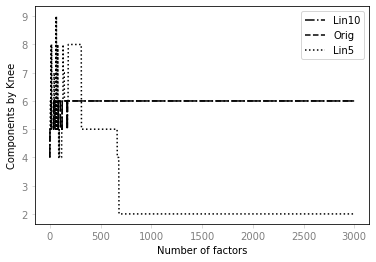

In [67]:
plot(lin5_knee, '-.', label='Lin10', color='black');
plot(lin10_knee, '--', label='Orig', color='black');
plot(djia_knee, ':', label='Lin5', color='black');
legend();
xlabel('Number of factors').set_color('black');
ylabel('Components by Knee').set_color('black');
tick_params(color='lightgrey', labelcolor='grey');

savefig('../knee.png')

## Calculating the NML for Different Values of $k$ and $n$

In [68]:
ns = list(range(40, 365, 40))

In [69]:
def nml(x, k):
    x = x.dropna()
    n, m = len(x), len(x.columns)
    p = decomposition.PCA().fit(X=x)
    tau = max(0.01, (1 - p.explained_variance_ratio_[: k].sum()) * x.var().sum())
    assert tau >= 0, tau
    
    d = {}
    
    d['\left( nm - kn \right) \Ln{\hat{\tau}}'] = (n * m - k * m) * np.log(n * m * tau) 
    d['k * m \Ln{ \FrobeniusSq{ X^T X }'] = k * m * np.log(np.dot(x.T, x).sum())
    d['(mn - kn - 1) \Ln{ mn \over mn - km}'] = (m * n - k * n - 1) * np.log( m * n / (m * n - k * m))
    d['-(mk + 1) \Ln{mk}'] = -(m * k + 1) * np.log(m * k)
    d = pd.Series(d)
    d['delta_max'] = m * k * np.log(m / np.sqrt(np.e)) + (k - 1) * np.log(1 / m / np.pi)
    d['sum'] = d.sum()
    d['n'] = n
    d['k'] = k
    d['upper'] = d['sum'] + d['delta_max']

    return d

def process(x):
    x = pd.concat([nml(x.head(n), k) for n, k in itertools.product(ns, range(1, len(x.columns)))], axis=1).T
    x['min_upper'] = x['upper'].groupby(x.n).transform(min)
    x['potential'] = x['sum'] < x['min_upper']
    return x

djia_res = process(djia)
djia_res.head()

,\left( nm - kn ight) \Ln{\hat{ au}},k * m \Ln{ \FrobeniusSq{ X^T X },(mn - kn - 1) \Ln{ mn \over mn - km},-(mk + 1) \Ln{mk},delta_max,sum,n,k,upper,min_upper,potential
0,12944.196396,304.588666,30.365344,-109.887591,90.953603,13260.216419,39.0,1.0,13351.170022,8716.848203,False
1,12384.179734,609.177332,59.487419,-260.009466,177.328490,12970.163509,39.0,2.0,13147.491998,8716.848203,False
2,11832.099150,913.765999,87.326594,-426.064352,263.703376,12670.830766,39.0,3.0,12934.534142,8716.848203,False
3,11261.169386,1218.354665,113.840691,-602.535196,350.078262,12340.907809,39.0,4.0,12690.986071,8716.848203,False
4,10773.841573,1522.943331,138.984736,-786.774318,436.453148,12085.448470,39.0,5.0,12521.901618,8716.848203,False


In [70]:
djia_res = process(djia)
lin5_res = process(lin5)
lin10_res = process(lin10)

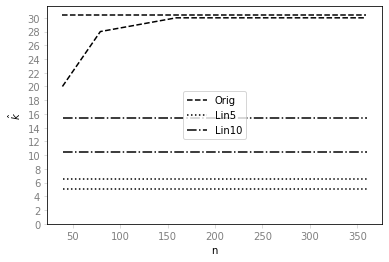

In [71]:
pot = djia_res[djia_res.potential]
y_delta = 0.1
plot(djia_res.n.unique(), pot.k.groupby(djia_res.n).min(), '--', label='Orig', color='black');
pot = lin5_res[lin5_res.potential]
plot(lin5_res.n.unique(), pot.k.groupby(lin5_res.n).min() - 0 * y_delta, ':', label='Lin5', color='black');
pot = lin10_res[lin10_res.potential]
plot(lin10_res.n.unique(), pot.k.groupby(lin10_res.n).min() + 5 * y_delta, '-.', label='Lin10', color='black');
legend();
pot = djia_res[djia_res.potential]
plot(djia_res.n.unique(), pot.k.groupby(djia_res.n).max() + 4 * y_delta, '--', color='black');
pot = lin5_res[lin5_res.potential]
plot(lin5_res.n.unique(), pot.k.groupby(lin5_res.n).max() -5 * y_delta, ':', color='black');
pot = lin10_res[lin10_res.potential]
plot(lin10_res.n.unique(), pot.k.groupby(lin10_res.n).max() - 6 * y_delta, '-.', color='black');
xlabel('n').set_color('black');
yticks(range(0, 31, 2))
ylabel('$\hat{k}$').set_color('black');
tick_params(color='lightgrey', labelcolor='grey');
savefig('../k.png')

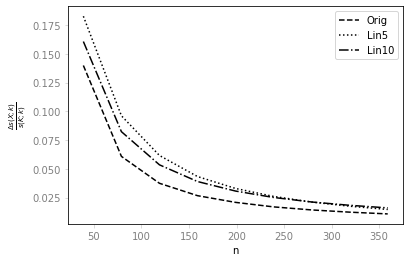

In [72]:
by_n = djia_res.groupby(djia_res.n).mean()
ratio = (by_n.delta_max / by_n['sum'])
ratio = ratio.interpolate()
plot(ratio.index, ratio.values, '--', label='Orig', color='black');
by_n = lin5_res.groupby(djia_res.n).mean()
ratio = (by_n.delta_max / by_n['sum'])
ratio = ratio.interpolate()
plot(ratio.index, ratio.values - 0.005, ':', label='Lin5', color='black');
by_n = lin10_res.groupby(djia_res.n).mean()
ratio = (by_n.delta_max / by_n['sum'])
ratio = ratio.interpolate()
plot(ratio.index, ratio.values, '-.', label='Lin10', color='black');
legend();
xlabel('n').set_color('black');
ylabel('$\\frac{\Delta s(X; k)}{s(K; k)}$').set_color('black');
tick_params(color='lightgrey', labelcolor='grey');
savefig('../ratio.png')